## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import copy
from math import floor
import matplotlib.pyplot as plt

## Settings

In [111]:
train_fraction = 0.1
n_clients = 5
distribution = "iid"
alpha = 0.1
train_batch_size = 64
test_batch_size = 64
public_batch_size = 64
n_samples_public = 400
n_epochs = 3

## Data loaders

In [104]:
def sample_train_data(train_fraction, transform):
    """ Sample a chosen fraction of the training dataset to use.

        Parameters:
        train_fraction  (float): Fraction of training data to use.
        transform       (torchvision.transforms.Compose): Collection of transforms to apply on data.

        Returns:
        torch.utils.data.Subset: Subset of training data.
    """
    train_data = MNIST(
        root='data', 
        train=True, 
        transform=transform, 
        download=True)
    n_samples = len(train_data.targets)
    index_limit = int(train_fraction * n_samples)
    chosen_indices = np.random.choice(torch.arange(n_samples), size=index_limit, replace=False)
    print(f"\nUsing {index_limit} training samples\n", flush=True)

    return Subset(train_data, chosen_indices)

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
train_data = sample_train_data(train_fraction, transform)


Using 6000 training samples



In [105]:
def generate_client_data(n_clients, distribution, alpha):
    """ Generate iid client data or non-iid by sampling from Dirichlet distribution.

        Parameters:
        n_clients       (int): Number of clients.
        distribution    (str): Indicator to sample iid or non-iid.
        alpha           (float): Concentration parameter for Dirichlet distribution.
    """
    labels = np.array([train_data[i][1] for i in range(len(train_data))])
    n_classes = len(np.unique(labels))
    partition_matrix = np.ones((n_classes, n_clients))

    # iid: Sample from each class until no samples left.
    if distribution == "iid":
        partition_matrix /= n_clients
        local_sets_indices = [np.array([], dtype=int) for _ in range(n_clients)]
        clients_iter = np.arange(n_clients)

        for i in range(n_classes):
            class_indices = np.where(labels == i)[0]

            clients_iter = clients_iter[::-1]
            samples_left = True
            while samples_left:
                for j in clients_iter:
                    if len(class_indices) == 0:
                        samples_left = False
                        break
                    else:
                        sample_idx = np.random.choice(len(class_indices))
                        local_sets_indices[j] = np.append(local_sets_indices[j], train_data.indices[class_indices[sample_idx]])
                        class_indices = np.delete(class_indices, sample_idx)

    # non-iid: Sample from dirichlet distribution.
    else:
        class_indices = []
        for i in range(n_classes):
            class_indices.append(np.array(range(len(labels)))[labels == i])
        valid_pm = False
        while not valid_pm:
            partition_matrix = np.random.dirichlet((alpha, )*n_clients, n_classes)
            valid_pm = all(np.sum(partition_matrix, axis=0) > 0.01)

        local_sets_indices = [[] for _ in range(n_clients)]
        for each_class in range(n_classes):
            sample_size = len(class_indices[each_class])
            for client in range(n_clients):
                np.random.shuffle(class_indices[each_class])
                local_size = floor(partition_matrix[each_class, client] * sample_size)
                local_sets_indices[client] += list(train_data.indices[class_indices[each_class][:local_size]])
                class_indices[each_class] = class_indices[each_class][local_size:]
    
    return local_sets_indices


local_sets_indices = generate_client_data(n_clients, distribution, alpha)


def get_train_data_loaders(batch_size):
    """ Get list of client training data loaders.

        Parameters:
        n_clients       (int): Number of clients.
        distribution    (str): iid/non-iid distributed data.
        alpha           (float): Concentration parameter for dirichlet distribution.
        batch_size      (int): Batch size for loading training data.

        Returns List[torch.utils.data.DataLoader]
    """
    client_data_loaders = []
    for client_indices in local_sets_indices:
            np.random.shuffle(client_indices)
            client_data_loaders.append(DataLoader(Subset(train_data.dataset, client_indices), batch_size))
    return client_data_loaders

client_data_loaders = get_train_data_loaders(train_batch_size)

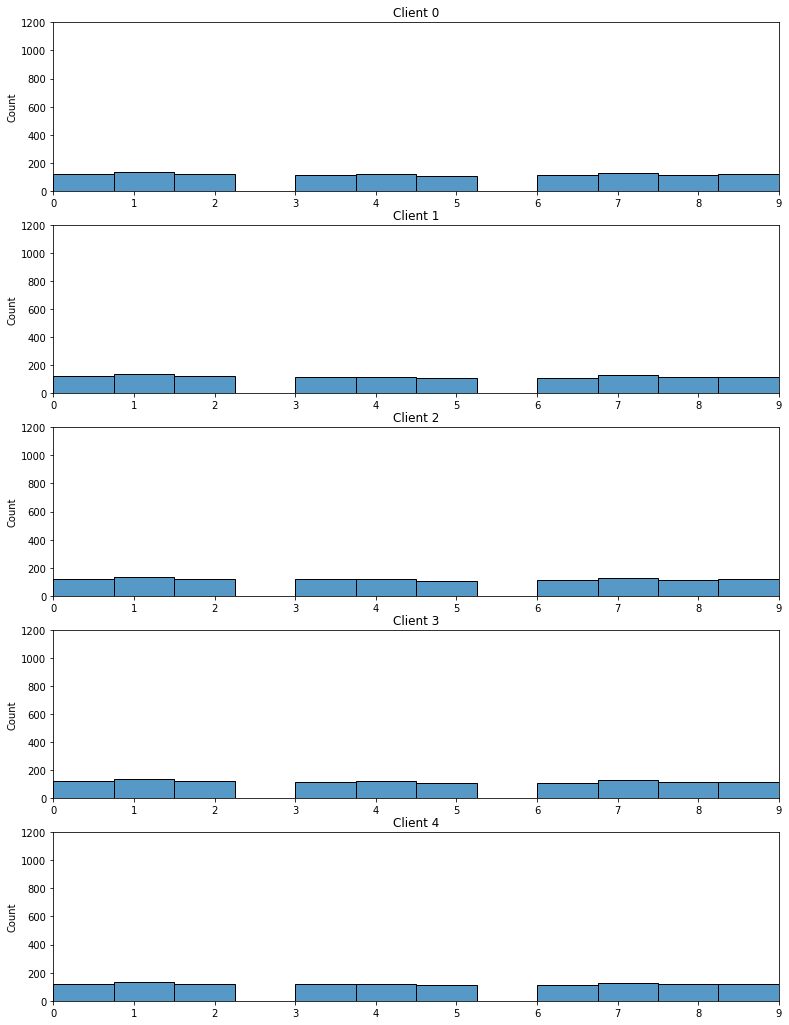

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
dataset = MNIST(root='data', train=True)

client_targets = [dataset.targets[indices].tolist() for indices in local_sets_indices]
n_clients = len(client_targets)

fig, ax = plt.subplots(n_clients, figsize=(13,18))
for i in range(n_clients):
    sns.histplot(client_targets[i], ax=ax[i])
    ax[i].set_title("Client {}".format(i))
    ax[i].set_xlim([0,9])
    ax[i].set_ylim([0,1200])

In [107]:
def split_test_public(n_samples):
    labels = np.array([y for (_, y) in test_data])
    n_classes = len(np.unique(labels))
    n_samples_per_class = int(n_samples / n_classes)
    all_indices = np.arange(len(labels))

    public_set_indices = []

    for i in range(n_classes):
        class_indices = np.where(labels == i)[0]
        chosen_indices = list(np.random.choice(class_indices, n_samples_per_class, replace=False))
        public_set_indices.extend(chosen_indices)

    # Fill up to n_samples.
    samples_left = n_samples - len(public_set_indices)
    indices_left = [x for x in all_indices if x not in public_set_indices]
    chosen_indices = list(np.random.choice(indices_left, samples_left, replace=False))
    public_set_indices.extend(chosen_indices)

    test_set_indices = [x for x in all_indices if x not in public_set_indices]

    return Subset(test_data, test_set_indices), Subset(test_data, public_set_indices)

test_data = MNIST(
    root='data', 
    train=False, 
    transform=transform, 
    download=True)

# test_data, public_data = split_test_public(n_samples_public)
idx_split = int(len(test_data) / 2)
public_data = Subset(test_data, np.arange(idx_split))
test_data = Subset(test_data, np.arange(idx_split, idx_split*2))
test_data_loader = DataLoader(test_data, test_batch_size)
public_data_loader = DataLoader(public_data, public_batch_size)

In [108]:
public_data_loader.dataset

(0.0, 9.0)

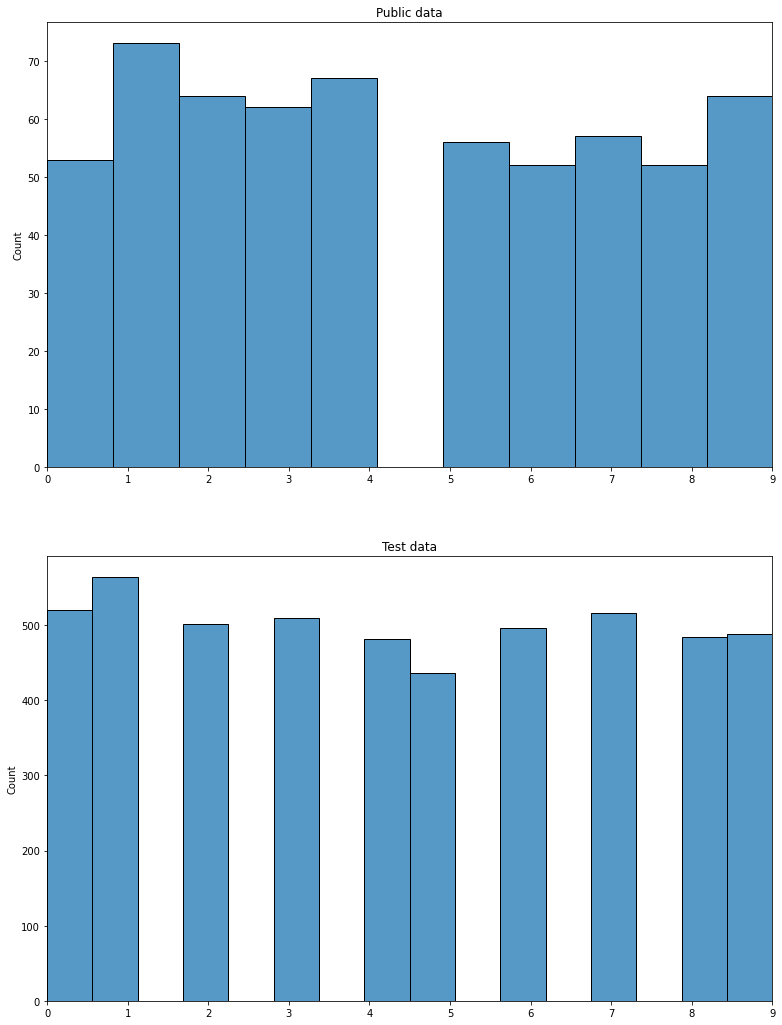

In [8]:
public_targets = public_data.dataset.targets[public_data.indices[:600]].tolist()
test_targets = test_data.dataset.targets[test_data.indices].tolist()


fig, ax = plt.subplots(2, figsize=(13,18))

sns.histplot(public_targets, ax=ax[0])
ax[0].set_title("Public data")
ax[0].set_xlim([0,9])
#ax[i].set_ylim([0,1200])

sns.histplot(test_targets, ax=ax[1])
ax[1].set_title("Test data")
ax[1].set_xlim([0,9])
#ax[i].set_ylim([0,1200])

## Models

In [9]:
class Mnist_Cnn(nn.Module):
    def __init__(self):
        super(Mnist_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        return output
    
class Mnist_Student(nn.Module):
    def __init__(self):
        super(Mnist_Student, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, 1, 2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(8 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [9]:
class Cifar_Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1, 2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Cifar10_Student(nn.Module):
    def __init__(self):
        super(Cifar10_Student, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(8 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

## Training clients

In [72]:
label_count_matrix = np.array([[torch.sum(train_data.dataset.targets[local_sets_indices[i]] == c) for c in range(10)] for i in range(n_clients)])

local_indices = [client_data_loaders[i].dataset.indices for i in range(n_clients)]
label_count_matrix = torch.tensor([[torch.sum(client_data_loaders[0].dataset.dataset.targets[local_indices[i]] == c) for c in range(10)] for i in range(n_clients)])
print(label_count_matrix)
print(torch.sum(label_count_matrix, axis=0))
print(torch.true_divide(label_count_matrix[0], torch.sum(label_count_matrix, axis=0)))
# label_count_matrix = np.array([np.zeros(10) for _ in range(n_clients)])
# for i in range(n_clients):
#     target_batches = [y.tolist() for (_, y) in client_data_loaders[i]]
#     targets = []
#     for target_batch in target_batches:
#         targets.extend(target_batch)
#     targets = np.array(targets)
#     label_count = np.array([np.sum(targets == c) for c in range(10)])
#     label_count_matrix[i] = label_count
# print(label_count_matrix)

tensor([[431,  72,   0, 621,   0,  32, 245, 326,   0,   0],
        [ 50,   2, 300,   0,   0, 497, 344,   0,   0, 183],
        [  5,   0,   0,   1, 293,   1,   0, 238,   6,   0],
        [ 10, 452, 332,   0,   0,   0,   0,   0,   0,  85],
        [ 62, 116,   0,   0, 276,   2,   0, 107, 553, 340]])
tensor([558, 642, 632, 622, 569, 532, 589, 671, 559, 608])
tensor([0.7724, 0.1121, 0.0000, 0.9984, 0.0000, 0.0602, 0.4160, 0.4858, 0.0000,
        0.0000])


In [112]:
local_model = Mnist_Cnn()
loss_function = nn.CrossEntropyLoss()

logits_ensemble1 = torch.zeros(5000, 10)
logits_ensemble2 = torch.zeros(5000, 10)
print("Starting training")

for i in range(n_clients):
    model = copy.deepcopy(local_model)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(n_epochs):
        train_loss = []
        model.train()
        for x, y in client_data_loaders[i]:
            optimizer.zero_grad()
            output = model(x)
            error = loss_function(output, y)
            error.backward()
            optimizer.step()
            
            train_loss.append(error.item())
            print(f"Client {i+1}/{n_clients}: "
                  f"Epoch {epoch+1}/{n_epochs}: "
                  f"Train loss: {sum(train_loss)/len(train_loss):.3f}", end="\r")
    print("\n")
    
    model.eval()
    logits_local = None
    with torch.no_grad():
        for x, _ in public_data_loader:
            if logits_local is None:
                logits_local = F.softmax(model(x), dim=1)
            else:
                logits_local = torch.cat((logits_local, F.softmax(model(x), dim=1)))
        
    # Increment average
    logits_ensemble1 = logits_ensemble1 + logits_local * torch.sum(label_count_matrix[i]) / torch.sum(torch.sum(label_count_matrix))
    logits_ensemble2 = logits_ensemble2 + logits_local * torch.sum(label_count_matrix[i])

Starting training
Client 1/5: Epoch 3/3: Train loss: 1.986

Client 2/5: Epoch 3/3: Train loss: 1.985

Client 3/5: Epoch 3/3: Train loss: 1.967

Client 4/5: Epoch 3/3: Train loss: 1.968

Client 5/5: Epoch 3/3: Train loss: 1.964



## Training student

In [122]:
print(logits_ensemble1)
print(torch.true_divide(logits_ensemble2.T, torch.sum(logits_ensemble2, axis=1)).T)


tensor([[0.0905, 0.1054, 0.0706,  ..., 0.2256, 0.0835, 0.1134],
        [0.1129, 0.0993, 0.1644,  ..., 0.0565, 0.1280, 0.0632],
        [0.0544, 0.2590, 0.0941,  ..., 0.1183, 0.1010, 0.0711],
        ...,
        [0.1050, 0.0971, 0.1524,  ..., 0.0566, 0.1342, 0.0733],
        [0.0663, 0.1451, 0.0752,  ..., 0.1159, 0.0942, 0.1294],
        [0.4701, 0.0260, 0.0640,  ..., 0.0648, 0.0778, 0.0618]])
tensor([[0.0905, 0.1054, 0.0706,  ..., 0.2256, 0.0835, 0.1134],
        [0.1129, 0.0993, 0.1644,  ..., 0.0565, 0.1280, 0.0632],
        [0.0544, 0.2590, 0.0941,  ..., 0.1183, 0.1010, 0.0711],
        ...,
        [0.1050, 0.0971, 0.1524,  ..., 0.0566, 0.1342, 0.0733],
        [0.0663, 0.1451, 0.0752,  ..., 0.1159, 0.0942, 0.1294],
        [0.4701, 0.0260, 0.0640,  ..., 0.0648, 0.0778, 0.0618]])


In [95]:
print(logits_ensemble.shape)
print(torch.sum(logits_ensemble, axis=1).shape)
a = torch.true_divide(logits_ensemble.T, torch.sum(logits_ensemble, axis=1)).T
print(a[0])

torch.Size([5000, 10])
torch.Size([5000])
tensor([0.2353, 0.0406, 0.0000, 0.3493, 0.0000, 0.0240, 0.1275, 0.2232, 0.0000,
        0.0000])


In [18]:
student_targets = torch.zeros(len(test_data.dataset), 10)
for i in range(n_samples_public):
    idx_public = public_data.indices[i]
    student_targets[idx_public] = logits_ensemble[i]

In [39]:
class StudentData(Dataset):
    def __init__(self, dataset, targets):
        
        self.dataset = dataset
        self.targets = targets
        self.indices = dataset.indices
            
    def __getitem__(self, index):
        if isinstance(index, list):
            data, _ = self.dataset[[i for i in index]]
            target = self.targets[[self.indices[i] for i in index]]
        else:
            data, _ = self.dataset[index]
            target = self.targets[self.indices[index]]
            
        return data, target
        
    
    def __len__(self):
        """Total number of samples"""
        return len(self.indices)

student_data = StudentData(public_data, student_targets)
student_data_loader = DataLoader(student_data, public_batch_size)
data_iter = iter(student_data_loader)
next(data_iter)

[tensor([[[[ 2.8088,  2.7706,  2.7833,  ...,  2.7833,  2.7833,  2.7833],
           [ 2.8215,  2.8088,  2.8215,  ...,  2.8215,  2.8215,  2.8215],
           [ 2.8215,  2.8088,  2.8088,  ...,  2.8088,  2.8088,  2.8088],
           ...,
           [ 2.8215,  2.8088,  2.8088,  ...,  2.8088,  2.8088,  2.8088],
           [ 2.8215,  2.8088,  2.8215,  ...,  2.8215,  2.8215,  2.8215],
           [ 2.8088,  2.7706,  2.7833,  ...,  2.7833,  2.7833,  2.7833]],
 
          [[ 2.8088,  2.7706,  2.7833,  ...,  2.7833,  2.7833,  2.7833],
           [ 2.8215,  2.8088,  2.8215,  ...,  2.8215,  2.8215,  2.8215],
           [ 2.8215,  2.8088,  2.8088,  ...,  2.8088,  2.8088,  2.8088],
           ...,
           [ 2.8215,  2.8088,  2.8088,  ...,  2.8088,  2.8088,  2.8088],
           [ 2.8215,  2.8088,  2.8215,  ...,  2.8215,  2.8215,  2.8215],
           [ 2.8088,  2.7706,  2.7833,  ...,  2.7833,  2.7833,  2.7833]],
 
          [[ 2.8088,  2.7706,  2.7833,  ...,  2.7833,  2.7833,  2.7833],
           [ 

In [44]:
model = Mnist_Student()
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs_student = 10

model.train()
for epoch in range(n_epochs_student):
    train_loss = []
    for x, y in student_data_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    print(f"Epoch {epoch+1}/{n_epochs_student}: "
          f"Train loss: {sum(train_loss)/len(train_loss):.3f}", end="\r")
    

RuntimeError: Given groups=1, weight of size [8, 1, 5, 5], expected input[64, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [17]:
correct = 0
total = 0

with torch.no_grad():
     for x, y in test_data_loader:
            output = model(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total +=1
                
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.762


In [25]:
alg = "fedavg+feded"
algs = alg.split("+")
ens = ["fede"]

In [27]:
any(alg in algs for alg in ens)

In [28]:
b

False

In [57]:
client_data_loaders[0]